# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [267]:
# Importamos las librerías que vamos a necesitar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from tqdm.notebook import tqdm
import gzip
from langdetect import detect
from textblob import TextBlob
from wordcloud import WordCloud
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

time: 0 ns (started: 2021-09-11 19:08:52 -03:00)


In [268]:
# Le doy formato a los gráficos
# sns.set_style("darkgrid")
sns.set_style("white")
plt.rc('font', size=10)
plt.rc('axes', titlesize=16)
plt.rc('figure', titlesize=16)
plt.rc('axes', labelsize=14) 
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

time: 0 ns (started: 2021-09-11 19:08:52 -03:00)


In [269]:
#Seteamos para que no utilice notacion cientifica
pd.options.display.float_format = '{:.4f}'.format
#Seteo para que el máximo de columnas que muestra al levantar una base sean 500
pd.set_option('display.max_columns',500)
#Estos códigos hacen que la visualización de la consola abarque toda la pantalla (sin los recortes a los costados). Tambien hacen que al mostrar dataframes podamos ver todas las columnas que tiene.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# Instanciamos método para ver el progreso de las operaciones sobre sobre los dataframes
tqdm.pandas()
# Indicador de tiempo de ejecución
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 0 ns (started: 2021-09-11 19:08:52 -03:00)


In [270]:
# Definimos si queres procesar el dataset crudo
READ_RAW = False
DETECT_LANG = False
GET_SUBJECTIVITY = False
GET_POLARITY = False

time: 0 ns (started: 2021-09-11 19:08:52 -03:00)


In [271]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

time: 0 ns (started: 2021-09-11 19:08:52 -03:00)


**Reviews**

In [272]:
if READ_RAW:
    contador = 0
    data_reviews = []
    # Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
    # abrira uno de cada tres, y asi.
    n = 10
    for l in tqdm(parse('steam_reviews.json.gz')):
        if contador%n == 0:
            data_reviews.append(l)
        else:
            pass
        contador += 1
    data_reviews = pd.DataFrame(data_reviews)

time: 0 ns (started: 2021-09-11 19:08:52 -03:00)


In [273]:
if READ_RAW:
    data_reviews.to_csv('data_reviews.csv', index_label='index')
else:
    data_reviews = pd.read_csv('data_reviews.csv')
    data_reviews.drop(columns='index', inplace=True)

time: 9.5 s (started: 2021-09-11 19:08:52 -03:00)


In [274]:
data_reviews.head(20)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1000,41.0000,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2000,1386.0000,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1000,1706.0000,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8000,2217.0000,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030368.0000,Product received for free,NaN
4,the_maker988,8.2000,18.0000,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396848.0000,NaN,NaN
5,Szudof,0.2000,155.0000,288690,0,2016-08-31,"<23:32:55> ""Pit"": Hello, my name is dominik di...",False,1,NaN,Product received for free,3.0000
6,Vonder,2.7000,264.0000,35600,3,2017-04-15,I like the art style and the idea but what a b...,False,1,76561198113497328.0000,NaN,NaN
7,LucaFox,4.0000,136.0000,620900,3,2017-09-11,"Very, very good game. I love dungeon crawlers,...",False,1,76561198146674480.0000,NaN,1.0000
8,rampage1209,34.8000,3.0000,1840,4,2018-01-04,WAY PAST COOL,False,1,76561198080474368.0000,NaN,NaN
9,Devil Azite,0.1000,548.0000,671270,5,2017-07-09,Putting a hat on your head has disasterous rep...,False,1,NaN,Product received for free,1.0000


time: 31 ms (started: 2021-09-11 19:09:01 -03:00)


In [275]:
data_reviews.isna().sum()

username            18
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text              1839
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

time: 203 ms (started: 2021-09-11 19:09:01 -03:00)


In [276]:
data_reviews.dropna(subset=['text'], axis=0, inplace=True)

time: 203 ms (started: 2021-09-11 19:09:02 -03:00)


In [277]:
data_reviews.isna().sum()

username            18
hours             2625
products          1564
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         460624
compensation    762923
found_funny     657709
dtype: int64

time: 172 ms (started: 2021-09-11 19:09:02 -03:00)


**Games**

In [278]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

time: 3.55 s (started: 2021-09-11 19:09:02 -03:00)


In [279]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.4900,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.9900,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.8300,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.9900,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.7900,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.9900,False,773570,NaN,NaN,NaN


time: 31 ms (started: 2021-09-11 19:09:06 -03:00)


Vamos a reducir las columnas de *'data_reviews'*

In [280]:
data_reviews.columns

Index(['username', 'hours', 'products', 'product_id', 'page_order', 'date',
       'text', 'early_access', 'page', 'user_id', 'compensation',
       'found_funny'],
      dtype='object')

time: 0 ns (started: 2021-09-11 19:09:06 -03:00)


In [281]:
df_reviews = data_reviews[['username', 'product_id', 'text', 'found_funny', 'hours']]
df_reviews.head()

,username,product_id,text,found_funny,hours
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,NaN,0.1000
1,Ariman1,328100,Addictive RPG ! Works fine on linux though it ...,NaN,13.2000
2,freakfantom,725280,Прикольная стрелялка. Взял дешево на распродаже.,NaN,0.1000
3,The_Cpt_FROGGY,631920,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,NaN,7.8000
4,the_maker988,35140,"This game was way to linear for me, and compar...",NaN,8.2000


time: 62 ms (started: 2021-09-11 19:09:06 -03:00)


In [282]:
# Creamos método para eliminar los caracteres que no sean letras
def cleanText(text):
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    text = re.sub("[^A-Za-z]"," ",str(text))
    return text

time: 0 ns (started: 2021-09-11 19:09:06 -03:00)


In [283]:
# Aplicamos el método a la columna de texto
df_reviews['text'] = df_reviews['text'].progress_apply(cleanText)

  0%|          | 0/777468 [00:00<?, ?it/s]

time: 23 s (started: 2021-09-11 19:09:06 -03:00)


C:\Users\elmai\AppData\Local\Temp/ipykernel_4252/3370166507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews['text'] = df_reviews['text'].progress_apply(cleanText)


In [284]:
df_reviews

,username,product_id,text,found_funny,hours
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,NaN,0.1000
1,Ariman1,328100,Addictive RPG Works fine on linux though it ...,NaN,13.2000
2,freakfantom,725280,,NaN,0.1000
3,The_Cpt_FROGGY,631920,Somewhere on Zibylon Zibyl...,NaN,7.8000
4,the_maker988,35140,This game was way to linear for me and compar...,NaN,8.2000
...,...,...,...,...,...
779302,Vidaar,252490,Summary Rust is a survival game created by Fa...,NaN,783.5000
779303,Nikolai Belinski,252490,Coolest Game Eva,NaN,55.1000
779304,RancorZealot,252490,Should you buy RUST Uh YES The BEST Survi...,NaN,203.5000
779305,Jerry,252490,Great game,NaN,139.8000


time: 15 ms (started: 2021-09-11 19:09:29 -03:00)


Detectar idioma del texto

In [285]:
# Creamos función para detectar idioma
def getLang(text):
    try:
        lang = detect(text)                                     
    except:
        lang = np.NaN
    return lang

time: 0 ns (started: 2021-09-11 19:09:29 -03:00)


In [286]:
if DETECT_LANG:
    df_reviews['lang'] = df_reviews['text'].progress_apply(getLang)

time: 0 ns (started: 2021-09-11 19:09:29 -03:00)


In [287]:
if DETECT_LANG:
    df_reviews.to_csv('df_reviews.csv', index_label='index')
else:
    df_reviews = pd.read_csv('df_reviews.csv', index_col='index')

time: 6.95 s (started: 2021-09-11 19:09:29 -03:00)


In [288]:
df_reviews.lang.unique()

array(['en', nan, 'so', 'pl', 'de', 'it', 'fr', 'ca', 'sw', 'tr', 'af',
       'hr', 'tl', 'no', 'es', 'ro', 'vi', 'nl', 'sq', 'cy', 'pt', 'id',
       'lv', 'et', 'hu', 'lt', 'da', 'sl', 'sk', 'fi', 'sv', 'cs', 'uk'],
      dtype=object)

time: 31 ms (started: 2021-09-11 19:09:36 -03:00)


In [289]:
code = pd.read_csv('lang_code3.csv')
code_dict = code.set_index('code').to_dict()['language_name']
df_reviews['lang'] = df_reviews['lang'].map(code_dict)

time: 94 ms (started: 2021-09-11 19:09:36 -03:00)


In [290]:
idiomas = df_reviews.groupby('lang').count()['username'].sort_values(ascending=False)

time: 265 ms (started: 2021-09-11 19:09:36 -03:00)


In [291]:
idiomas.index

Index(['English', 'Somali', 'German', 'Afrikaans', 'Tagalog', 'Welsh',
       'Norwegian', 'Danish', 'Romanian', 'Spanish', 'Dutch', 'Catalan',
       'French', 'Indonesian', 'Italian', 'Polish', 'Portuguese', 'Turkish',
       'Estonian', 'Swahili', 'Slovenian', 'Albanian', 'Croatian',
       'Vietnamese', 'Swedish', 'Finnish', 'Hungarian', 'Slovak', 'Lithuanian',
       'Latvian', 'Czech', 'Ukrainian'],
      dtype='object', name='lang')

time: 0 ns (started: 2021-09-11 19:09:36 -03:00)


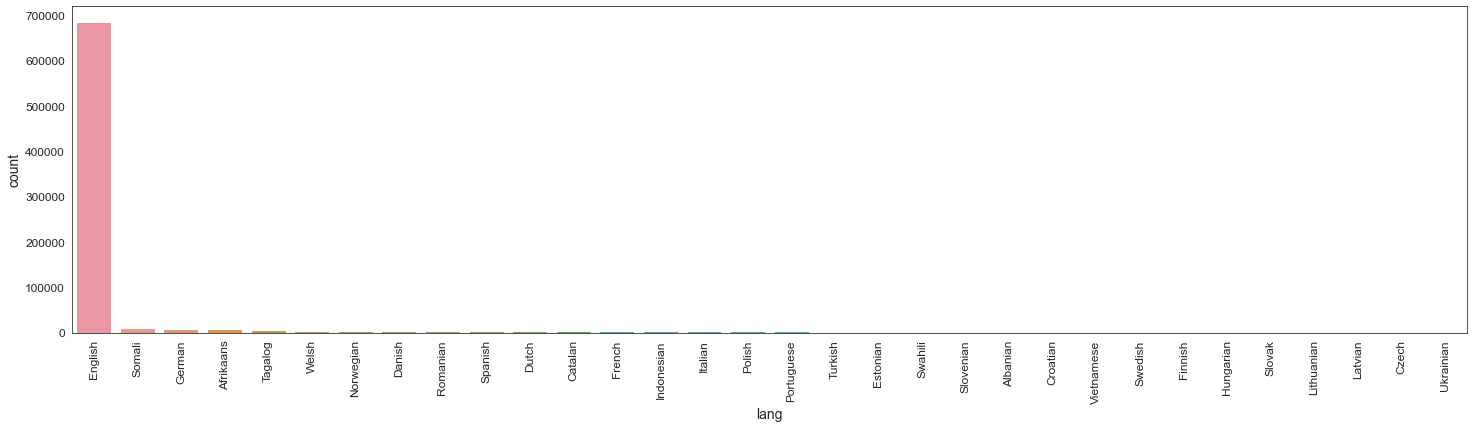

time: 1.11 s (started: 2021-09-11 19:09:36 -03:00)


In [292]:
# Graficamos el conteo de los distintos idiomas encontrados en el dataset
plt.figure(figsize=(25,6))
sns.countplot(data=df_reviews, x='lang', order=idiomas.index[0:])
plt.xticks(rotation=90)
plt.show()

Vemos claramante que el idioma predominantes es el inglés. Algo llamativo es que el segundo más abundante es el "Somalí". Vamos a analizar más en detalle, filtrando esas instancias.

In [293]:
df_reviews[df_reviews.lang == 'Somali'].head(20)

,username,product_id,text,found_funny,hours,lang
index,,,,,,
31,JessetheGengar,302390,baaaddddddd,NaN,0.4000,Somali
247,69:The Best Position,271590,good,NaN,176.3000,Somali
354,Santiago ♥D,308040,bad,1.0000,1.3000,Somali
445,brokensteelcache,224900,too good to play,1.0000,1.3000,Somali
601,𝖊𝖃𝖔 | Psycocat,308040,good game,NaN,3.2000,Somali
617,Vukishaa,308040,good,NaN,3.3000,Somali
698,Dicather,441050,YEAH IT CAN INTO SPACE,NaN,1.6000,Somali
718,MyAcidicPapaya,341720,good,NaN,0.8000,Somali
741,✪ B1ACKOUT,271590,good game,NaN,12.1000,Somali


time: 63 ms (started: 2021-09-11 19:09:37 -03:00)


Por lo que podemos observar, se trata de una mala predicción, ya que los comentarios están en inglés. Por alguna razón (quizás por las faltas de ortografía) los etiqueta como Somalí.
De todos modos, siendo que la cantidad de comentarios predichos como Inglés representan un gran porcentaje, vamos a eliminar aquellas instancias en otro idioma.

In [294]:
mask = df_reviews.lang == 'English'
df_reviews.drop(df_reviews[~mask].index, inplace=True)
df_reviews

,username,product_id,text,found_funny,hours,lang
index,,,,,,
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,NaN,0.1000,English
1,Ariman1,328100,Addictive RPG Works fine on linux though it ...,NaN,13.2000,English
3,The_Cpt_FROGGY,631920,Somewhere on Zibylon Zibyl...,NaN,7.8000,English
4,the_maker988,35140,This game was way to linear for me and compar...,NaN,8.2000,English
5,Szudof,288690,Pit Hello my name is dominik di...,3.0000,0.2000,English
...,...,...,...,...,...,...
779301,SepticFalcon,252490,A good laugh with friends cannot wait till mo...,NaN,334.9000,English
779302,Vidaar,252490,Summary Rust is a survival game created by Fa...,NaN,783.5000,English
779304,RancorZealot,252490,Should you buy RUST Uh YES The BEST Survi...,NaN,203.5000,English


time: 250 ms (started: 2021-09-11 19:09:37 -03:00)


In [295]:
# Instanciamos el tokenizer
tokenizer=RegexpTokenizer("\w+")

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
stemmer = PorterStemmer()

# Traemos las stopwords
stopwords = set(stopwords.words('english'))

time: 0 ns (started: 2021-09-11 19:09:38 -03:00)


In [296]:
# Creamos método para aplicar la Normalizacion y luega el Stemming a cada instancia
def processText(text):
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    text=re.sub("[^a-zA-Z]"," ",str(text))
    # Pasamos todo a minúsculas
    text=text.lower()
    # Tokenizamos para separar las palabras del titular
    text=tokenizer.tokenize(text)
    # Eliminamos las palabras de menos de 4 letras
    text = [palabra for palabra in text if len(palabra)>3]
    # Sacamos las Stopwords
    text = [p for p in text if not p in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
#     text = [stemmer.stem(t) for t in text]
    # Por ultimo volvemos a unir el titular
    text = " ".join(text)
    
    return text

time: 0 ns (started: 2021-09-11 19:09:38 -03:00)


In [297]:
# Aplicamos la transformación
df_reviews['cleaned_text'] = df_reviews['text'].progress_apply(processText)

  0%|          | 0/685202 [00:00<?, ?it/s]

time: 49.8 s (started: 2021-09-11 19:09:38 -03:00)


In [298]:
# Mostramos el dataset limpio
df_reviews.iloc[np.random.choice(df_reviews.index, size=5)]

IndexError: positional indexers are out-of-bounds

time: 141 ms (started: 2021-09-11 19:10:28 -03:00)


In [ ]:
df_reviews.head(10)

In [ ]:
import nltk
nltk.download('wordnet')

In [ ]:
nltk.download('averaged_perceptron_tagger')

In [ ]:
def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity


def polarity(text):
    return TextBlob(text).sentiment.polarity

In [ ]:
if GET_SUBJECTIVITY:
    df_reviews['subj'] = df_reviews['text'].progress_apply(subjectivity)
    df_reviews.to_csv('df2_reviews.csv', index_label='index')
else:
    df2_reviews = pd.read_csv('df2_reviews.csv')

In [ ]:
if GET_POLARITY:
    df_reviews['pola'] = df_reviews['text'].progress_apply(polarity)
    df_reviews.to_csv('df2_reviews.csv', index_label='index')
else:
    df2_reviews = pd.read_csv('df2_reviews.csv')

In [ ]:
df2_reviews.sort_values(by='subj').iloc[650000:650050]

In [ ]:
df2_reviews.drop('index', axis=1, inplace=True)

In [ ]:
# Graficamos para ver la distribución de las variables calculadas.

x = df2_reviews.subj[::100]
y = df2_reviews.pola[::100]

plt.figure(figsize=(20,12))
kdeplot = sns.jointplot(x, y, kind="kde", cbar=True, cmap="Blues", fill=True)

plt.subplots_adjust(left=0.1, right=1, top=1, bottom=0.1)

pos_joint_ax = kdeplot.ax_joint.get_position()
pos_marg_x_ax = kdeplot.ax_marg_x.get_position()
kdeplot.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width,
                               pos_joint_ax.height])
kdeplot.fig.axes[-1].set_position([1.05, pos_joint_ax.y0, .07, pos_joint_ax.height])

# get the current colorbar ticks
cbar_ticks = kdeplot.fig.axes[-1].get_yticks()
# get the maximum value of the colorbar
_, cbar_max = kdeplot.fig.axes[-1].get_ylim()
# change the labels (not the ticks themselves) to a percentage
kdeplot.fig.axes[-1].set_yticklabels([f'{t / cbar_max * 100:.0f} %' for t in cbar_ticks])

kdeplot.fig.axes[0].set_xlabel("Subjectividad")
kdeplot.fig.axes[0].set_ylabel("Polaridad")

plt.show()

In [ ]:
df2_reviews.dropna(axis=0, subset=['username'], inplace=True)
df2_reviews.isna().sum()

In [ ]:
reviews_count = df2_reviews.groupby('username').count().text.sort_values(ascending=False).reset_index().rename(columns={'text':'count'})
reviews_count.head()

In [ ]:
plt.figure(figsize=(30,10))
g = sns.barplot(data=reviews_count[:200], x='username', y='count')
plt.xticks(rotation=90)
plt.show()

In [ ]:
df2_reviews['rating'] = df2_reviews.apply(lambda x: (x['pola'] + 1) * 5/2 , axis=1)

In [ ]:
df2_reviews

In [ ]:
df_ratings = df2_reviews.groupby('product_id').agg({'rating':['count','mean']}).reset_index()
df_ratings.columns = ['product_id', 'count', 'mean']
df_ratings.sort_values(by='mean', ascending=False, inplace=True)
df_ratings.reset_index(inplace=True, drop=True)
df_ratings

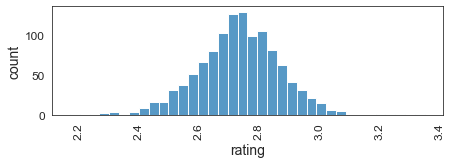

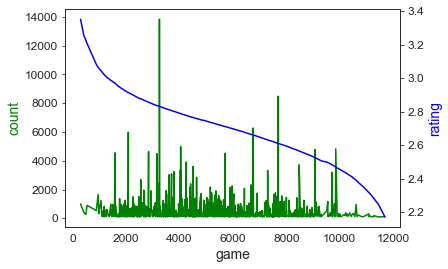

time: 640 ms (started: 2021-09-11 17:48:33 -03:00)


In [157]:
df_filter = df_ratings[df_ratings['count'] >= 100]

plt.figure(figsize=(7,2))
sns.histplot(data=df_filter, x='mean')
plt.ylabel('count')
plt.xlabel('rating')
plt.xticks(rotation=90)
plt.show()

x = df_filter.index
y1 = df_filter['count']
y2 = df_filter['mean']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('game')
ax1.set_ylabel('count', color='g')
ax2.set_ylabel('rating', color='b')

plt.show()

In [300]:
df_games = data_games.copy()
df_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.4900,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.9900,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.8300,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.9900,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.7900,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.9900,False,773570,NaN,NaN,NaN


time: 31 ms (started: 2021-09-11 19:11:09 -03:00)


In [301]:
df_games.shape

(32135, 16)

time: 0 ns (started: 2021-09-11 19:11:09 -03:00)


In [302]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB
time: 78 ms (starte

In [303]:
df_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

time: 47 ms (started: 2021-09-11 19:11:09 -03:00)


In [312]:
# Hay dos juegos que no tienen 'id' asociado
# Veamos cuales son
df_games[df_games.id.isna()]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
74,NaN,NaN,NaN,NaN,http://store.steampowered.com/,NaN,NaN,14.9900,NaN,NaN,19.9900,False,NaN,NaN,NaN,NaN
30961,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",NaN,NaN,"[Single-player, Steam Achievements, Steam Trad...",19.9900,False,NaN,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


time: 31 ms (started: 2021-09-11 19:13:54 -03:00)


In [304]:
# df_games.dropna(subset=['id'], axis=0, inplace=True)

time: 0 ns (started: 2021-09-11 19:11:09 -03:00)


In [310]:
df_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

time: 47 ms (started: 2021-09-11 19:13:05 -03:00)


In [306]:
# Me quedo con las columnas: [app_name, release_date, tags, id, sentiment, metascore]
# En vez de quedarme con 'title', para los nombres de los juegos me quedo con 'app_name', ya que title tiene muchos 'NaN'
columns = ['app_name', 'release_date', 'tags', 'id', 'sentiment', 'metascore']

df2_games = data_games[columns]
df2_games.head()

,app_name,release_date,tags,id,sentiment,metascore
0,Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",761140,NaN,NaN
1,Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",643980,Mostly Positive,NaN
2,Real Pool 3D - Poolians,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",670290,Mostly Positive,NaN
3,弹炸人2222,2017-12-07,"[Action, Adventure, Casual]",767400,NaN,NaN
4,Log Challenge,NaN,"[Action, Indie, Casual, Sports]",773570,NaN,NaN


time: 15 ms (started: 2021-09-11 19:11:10 -03:00)


In [307]:
# Verifico los tipos de datos
df2_games.dtypes

app_name        object
release_date    object
tags            object
id              object
sentiment       object
metascore       object
dtype: object

time: 0 ns (started: 2021-09-11 19:11:10 -03:00)


In [308]:
# Convierto la columns "id" a tipo numérica (integer)
df2_games['id'] = df2_games['id'].astype(str).astype(int)
df2_games.dtypes

ValueError: invalid literal for int() with base 10: 'nan'

time: 47 ms (started: 2021-09-11 19:11:10 -03:00)


In [ ]:
df2_games.head()

In [ ]:
df2_games.info()

In [ ]:
df2_games = df2_games.set_index('id')

In [ ]:
df_filter.info()

In [ ]:
df_filter['app_name'] = df2_games.app_name.loc[df_filter.product_id].values
df_filter['sentiment'] = df2_games.sentiment.loc[df_filter.product_id].values
df_filter.head(20)

In [ ]:
df_filter.dtypes

In [ ]:
df_filter.product_id

In [ ]:
df_filter.shape

In [ ]:
df2_games.app_name.loc[df_filter.product_id.iloc[2]]

In [ ]:
df2_games.loc[df_filter.product_id].app_name.values.shape